# This notebook is copied from treePower.ipynb for parameter testing. 

In [1]:
import numpy as np
import pandas
from scipy import sparse
from scipy.optimize import broyden1
from functools import partial
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline

import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
import scipy

print("Scipy version is", scipy.__version__)

Python 3 version is 3.8.10 (default, Jun 22 2022, 20:18:18) 
[GCC 9.4.0]
Matplotlib version is 3.5.1
Numpy version is 1.22.3
Scipy version is 1.8.0


In [2]:
#Define parameters
"""
n_x -- number of grid points, radially; interior points index from 1 to n_x - 1; bdry points are 0 and n_x.
n_t -- number of time steps
plot_at -- grid point at which a temperature curve is drawn
diff_at -- list of two grid points where the temp difference is computed
radius -- radius of tree, m
height -- height of tree, m
thermal_conductivity -- thermal conductivity of the tree, unit W/(mK)
rho -- density of tree trunk, unit kg/m^3
specific_heat -- specific_heat, unit J/(kgK)
albedo -- albedo constant; taken to be 0.3 from Potter Andresen pg.3
sigma -- Stefan–Boltzmann constant, 5.67 × 10 − 8 W ⋅ m − 2 ⋅ K − 4
"""
n_x = 150
n_t = 150
sigma = 5.76e-8
radius = 0.135
thermal_conductivity = 0.16 # Notation Kt in code; k in paper # pg 3-17, wood handbook.
rho = 720
specific_heat = 1300 # table 3-12, at 27 degrees, MC 12% (wood handbook)
albedo = 0.3 # 0.3 is concrete; 0.18, is grass#

time = np.linspace(0, 24, n_t, endpoint = False)
dt = time[1] - time[0]
# Boundary conditions at trunk[0] and trunk[n_x]; Temperature[j] at trunk[j]; in matrix, only index from 1 to n_x-1 (labeled m)
trunk = np.linspace(0, radius, n_x + 1)   
dr = radius / n_x

index1 = int(n_x/3)
index2 = 2 * index1

In [3]:
#### Read measured temp data-- only need bark and a mid point for validation

colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

    ##########
coreTemp = dataTemp.s135_3[2:416].tolist() # Oct 21 -- core temp is west, at 13.5cm, at 2m high
coreTempnp = np.asarray([float(t) for t in coreTemp])
coreTempnp = coreTempnp + 273.15
core_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,coreTempnp.size),coreTempnp)
    ##########
    
barkTemp = dataTemp.w_ext_35[2:416].tolist() # Oct 21 -- bark temp is West, at bark, at 3.5m high
barkTempnp = np.asarray([float(v) for v in barkTemp])
barkTempnp = barkTempnp + 273.15
bark_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,barkTempnp.size),barkTempnp)
    
    ##########
midTemp1 = dataTemp.w9_3[2:416].tolist() # Oct 21 -- West, at 9cm, at 3m high
midTemp1np = np.asarray([float(t) for t in midTemp1])
midTemp1np = midTemp1np + 273.15
mid_temp1 = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,midTemp1np.size),midTemp1np)
    ##########
    
midTemp2 = dataTemp.n45_3[2:416].tolist() # Oct 21 -- North, at 4.5cm, at 3m high
midTemp2np = np.asarray([float(t) for t in midTemp2])
midTemp2np = midTemp2np + 273.15
mid_temp2 = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,midTemp2np.size),midTemp2np)
    ##########
    
initTemp = np.array([core_temp[0], mid_temp1[0], mid_temp2[0], bark_temp[0]])
init_temp = np.interp(np.linspace(0,radius,n_x), np.linspace(0,radius,initTemp.size),initTemp)
    ##########


In [4]:
### test parameters: Kt -- thermal conductivity; rho--density; c -- specific heat

def mol(c = 10, Kt = 1.8, rho = 720): 
    a = rho * c / Kt
    beta = dt / (a * dr ** 2)
    
    T0 = init_temp # initialize temperature with measured initial condition

    alpha = np.linspace(1, n_x - 1, n_x - 1)# index from 0 to n_x - 2; cor. to points at 1 to n_x - 1
    for j in range(alpha.size):
        alpha[j] = dt / (4 * a * trunk[j + 2] * dr) - 0.5 * beta
    
    gamma = np.linspace(1, n_x - 1, n_x - 1)
    for j in range(gamma.size):
        gamma[j] = dt / (4 * a * trunk[j + 1] * dr) + 0.5 * beta
    
    # for the right hand side vector- alpha1 if Dirichlet at center; gammam is used for Dirichlet at the bark
    
    alpha1 = dt / (4 * a * trunk[1] * dr) - 0.5 * beta
    gammam = dt / (4 * a * trunk[-1] * dr) + 0.5 * beta
    
    # system of Ax_{n+1} = Bx_{n} + v    
    
    # use Neumann condition-- no flux condition
    gamma[0] = beta

    A = sparse.diags([alpha, np.ones(n_x) + beta, -gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    B = sparse.diags([-alpha, np.ones(n_x) - beta, gamma], [-1, 0, 1], shape=(n_x, n_x)).toarray()
    
    T1 = np.zeros((n_x,1))
    
    # soln to include initial temperature
    soln = [T0]
    
    ## time stepping: step1 compute B * T0; step2 rhs = B * T0 + v; step2 solve for T1 with T1 = A^-1 * rhs
    for time in range(n_t - 1):
        rhs = B.dot(T0)
        # with measured bark temperature
        rhs[-1] = rhs[-1] + gammam * (bark_temp[time] + bark_temp[time + 1])
        # with measured air temperature
#         rhs[-1] = rhs[-1] + gammam * (air_temp[time] + air_temp[time + 1])
        T1 = np.linalg.solve(A, rhs) 
        T0 = T1
        
        soln.append(T0) # start saving the solutions from time step 1 
        solnArray = np.array(soln)
        
    return solnArray    

## Results from the experiments-- visualization

The combination of $a = \rho \cdot c/Kt$ is not the only impact- as see by running 

*solution = mol(1, 0.18, 720)* and *solution = mol()*

It is a possible numerical error due to the division

In [18]:
# test cell-- parameter combo -- test case: solution = mol() with default parameter

K = np.linspace(0.05, 2.0, 196)
error_Kt = np.zeros((4,196))
for j in range(196):
    solution = mol(c = 10, Kt = K[j], rho = 720)
    temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
    error_Kt[:,j] = temp

    
C = np.linspace(10, 3700, 370)
error_C = np.zeros((4,370))
for j in range(370):
    solution = mol(c = C[j], Kt = 1.6, rho = 720)
    temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
    error_C[:,j] = temp
    
    
rho1 = np.linspace(570, 780, 22)
error_rho = np.zeros((4,22))
for j in range(22):
    solution = mol(c = 10, Kt = 1.6, rho = rho1[j])
    temp = np.array([np.abs(np.max(solution[:,0]-core_temp)), np.abs(np.max(solution[:,index1]-mid_temp1)), np.abs(np.max(solution[:,index2]-mid_temp2)), np.abs(np.max(solution[:,-2]-bark_temp))])
    error_rho[:,j] = temp

In [19]:
# print index and the corresponding values of c, Kt, rho

# a=np.array([1,2,3,3])

# np.where(a==np.max(a))[0]

print(error_Kt[0,:].min(), error_Kt[1,:].min(),error_Kt[2,:].min(),error_Kt[3,:].min())

print(error_C[0,:].min(), error_C[1,:].min(),error_C[2,:].min(),error_C[3,:].min())

print(error_rho[0,:].min(), error_rho[1,:].min(),error_rho[2,:].min(),error_rho[3,:].min())

0.22714464409938273 0.0023785588000464486 0.003216447261365829 0.5281477681745059
0.5042137484161344 0.1861404877042787 0.17684405698554428 0.5671025203234876
0.21483822707818945 0.005033557046999704 0.0008283617341362515 0.5263249917564394


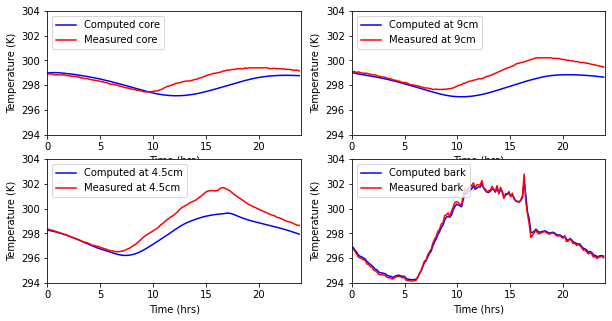

In [6]:
# visualize

# fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# ax[0,0].plot(time, solution[:,0], 'b-', label='Computed core')
# ax[0,0].plot(time, core_temp, 'r-', label='Measured core')
# ax[0,0].legend(loc="upper left")
# ax[0,0].axis([0, 24, 294, 304])
# ax[0,0].set_xlabel('Time (hrs)')
# ax[0,0].set_ylabel('Temperature (K)')


# ax[0,1].plot(time, solution[:,index1], 'b-', label='Computed at 9cm')
# ax[0,1].plot(time, mid_temp1, 'r-', label='Measured at 9cm')
# ax[0,1].legend(loc="upper left")
# ax[0,1].axis([0, 24, 294, 304])
# ax[0,1].set_xlabel('Time (hrs)')
# ax[0,1].set_ylabel('Temperature (K)')

# ax[1,0].plot(time, solution[:,index2], 'b-', label='Computed at 4.5cm')
# ax[1,0].plot(time, mid_temp2, 'r-', label='Measured at 4.5cm')
# ax[1,0].legend(loc="upper left")
# ax[1,0].axis([0, 24, 294, 304])
# ax[1,0].set_xlabel('Time (hrs)')
# ax[1,0].set_ylabel('Temperature (K)')


# ax[1,1].plot(time, solution[:,-2], 'b-', label='Computed bark')
# ax[1,1].plot(time, bark_temp, 'r-', label='Measured bark')
# ax[1,1].legend(loc="upper left")
# ax[1,1].axis([0, 24, 294, 304])
# ax[1,1].set_xlabel('Time (hrs)')
# ax[1,1].set_ylabel('Temperature (K)')

# plt.show()
    

In [7]:
# ### Read weather data-- do not need when use measured bark data as outer boundary condition

# colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'temperature', 'air_pressure', 'solar_DNI']

# dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)
   
# temp = dataWeather.temperature[2:145].tolist() # use data from Oct 21
# tempnp = np.asarray([float(t) for t in temp])
    
# tempnp = tempnp + 273.15

# windspeed = dataWeather.wind_speed[2:145].tolist()
# windspeednp = np.asarray([float(v) for v in windspeed])

# solar = dataWeather.solar_DNI[2:145].tolist()
# solarnp = np.asarray([float(v) for v in solar])

# air_temp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,tempnp.size),tempnp)
# windspeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,windspeednp.size),windspeednp)
# solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,solarnp.size),solarnp)